In [1]:
#Set TIME FREQUENCY
#options are: 'Monthly', 'Weekly', 'Quarterly'
Time_freq = 'Monthly'
countries = ['DE', 'ES', 'UK', 'FR', 'CH', 'IT', 'PT']


In [2]:
%%capture

# Imports & Settings
!pip install -r requirements.txt 

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant


In [4]:
from datetime import datetime

In [5]:
from rv_standard_functions_git import *
from evaluate import *
from aws import *


In [6]:
import_settings()
from math import exp,log
import boto3
import pickle
import xgboost as xgb
import datetime
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) 

In [7]:
# Select for which countries to run price index
#countries = ['AT','BE','CH','CZ','DE','ES','FI','FR','GR','HU','IE','IT','LU','NL','NO','PL','PT','RO','SE','SK','UK'] #DK
#countries = ['DE', 'ES', 'PT']

# Select the S3 parameters
bucket = 'lpd.data.sci.intermediate.tst'
s3 = boto3.resource('s3')

# Select whether or not to use a specific fueltype cars
use_specific_fueltype = True
fueltype = 'Diesel'

export_date = '20200607'

begin_date = '2013-01-31'
end_date = '2019-12-31'
train_start = pd.to_datetime('2013-01-31').date()
train_end = pd.to_datetime('2019-12-31').date()

model_ids= {'AT': 20200318165807,
            'BE': 20200319091537,
            'CH': 20200318090849,
            'CZ': 20200318170154,
            'DE': 20200317162835,
            'ES': 20200323142052,
            'FI': 20200318165902,
            'FR': 20200323141426,
            'GR': 20200319162236,
            'HU': 20200408144557, 
            'IE': 20200119213944,
            'IT': 20200318145707,
            'LU': 20200410104540,
            'NL': 20200323142613,
            'NO': 20200319185741,
            'PL': 20200319191135,
            'PT': 20200318165833,
            'RO': 20200323141335,
            'SE': 20200319162206,
            'SK': 20200318164849,
            'UK': 20200319093741   
           } 

In [8]:
# Generic function to clean the names of the car makes
def clean_make_names(data):
    data['make'] = data['make'].apply(lambda x: x if x[-3:]!=' EL' else x[:-3])
    data['make'] = data['make'].apply(lambda x: x if x[-4:]!=' T.T' else x[:-4])
    data['make'] = data['make'].apply(lambda x: x if x[-3:]!=' TT' else x[:-3])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!=' T.T.' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-9:]!=' INDUSTR.' else x[:-9])
    data['make'] = data['make'].apply(lambda x: x if x[-8:]!=' INDUST.' else x[:-8])
    data['make'] = data['make'].apply(lambda x: x if x[-11:]!=' BEDR.WAGEN' else x[:-11])
    data['make'] = data['make'].apply(lambda x: x if x[-4:]!=' 2+2' else x[:-4])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!=' IND.' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!=' V.I.' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-4:]!='-NFZ' else x[:-4])
    data['make'] = data['make'].apply(lambda x: x if x[-7:]!=' TRUCKS' else x[:-7])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!='-BENZ' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!=' BENZ' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-5:]!=' Benz' else x[:-5])
    data['make'] = data['make'].apply(lambda x: x if x[-7:]!=' TRUCKS' else x[:-7])
    data['make'] = data['make'].apply(lambda x: x if x[-3:]!='-VI' else x[:-3])
    data['make'] = data['make'].apply(lambda x: x if x.isupper()==True else x.upper())
    data['model_cons'] = np.where((data.model_cons == 'PASSAT CC'),'PASSAT',data.model_cons)
    data['make'] = np.where((data.make == 'VW'),'VOLKSWAGEN',data.make)
    data['make'] = np.where((data.make == 'Audi'),'AUDI',data.make)

    # Create make_model variable
    data['make_model'] = data['make'] + '_' + data['model_cons']
    
    return data 

# Create graphs Time Dummy

### Month all

In [9]:
def mean_absolute_percentage_error(y_true, y_pred, print_ = False):
    """
    Function to calculate the mean absolute percentage errors.
    Takes lists as input"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if print_:
        print(np.abs((y_true - y_pred) / y_true))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [10]:
def TD_graph(data, top10 = False, graph_name = '', frequency = 'Monthly'):
    """
    Function that applies the hedonic time dummy method for creating an index.
    """
    
    import datetime    
    
    #Add a new variable for the period of the sale date
    if frequency == 'Monthly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('M'))
    elif frequency == 'Quarterly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('Q'))
    elif frequency == 'Weekly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('W'))
    
    #Give all periods in benchmark year the same 'date'
    unique_ts = data.freq_ts.unique()
    unique_ts.sort()
    unique_ts_1 = [x for x in unique_ts if x.to_timestamp().date() <= datetime.date(2013, 12, 31)]
    unique_ts_2 = [x for x in unique_ts if x.to_timestamp().date() > datetime.date(2013, 12, 31)]
        
    if top10:
        data = data.loc[data.model_cons.isin(data.model_cons.value_counts().index[:10])]

    data.loc[data.freq_ts.isin(unique_ts_1), 'freq_ts'] = None
    
    
    #Only look at a specifif fueltype if necessary
    if use_specific_fueltype:
        data = data.loc[data['fueltype'] == fueltype]

    # Splitting the data will aslo dummify the period variable
    data, train, test, X_train, X_test, y_train, y_test, weights = split_preprocess_data(data, params['categorical_vars'], 
                                                                                     params['continuous_vars'])

    # Use log of sellprice as a target
    y_train = np.log(y_train.values)

    # Train a linear model
    model_linear = train_linear(X_train, y_train)

    # Store the variable coefficietns in a dictionary
    coefficients = model_linear.params.to_dict()



    ts_coefficients = []

    # Get the the coefficients from the trained model for 2020
    for k,v in coefficients.items():
        if k[:7]=='freq_ts':
            ts_coefficients.append(v)

        # Take the exponent of the period coeficients to trace the development
    ts_coefficients = np.exp(np.array(ts_coefficients ,dtype=np.float128))
    
    from datetime import datetime


    # Creating a final dataframe and plotting the results
    dataset = pd.DataFrame({'Period': unique_ts_2, '{}'.format(graph_name): ts_coefficients})
    dataset = dataset.set_index('Period')
    return dataset, model_linear

### Hedonic

In [11]:
def Hed_Graph(data, frequency = 'Monthly'):
    
    
    factors_x = [ 'model_encoded_bt',
    'mileage',
     'duration',
     'engine_capacity',
     'catalog_price_car_options',
     'model_age',
     'engine_power',
     'gross_weight',
     'tare_weight',
     'segmentation_encoded',
     'catalog_price_accessories']

    #factors_y = ['sellprice%']
    factors_y = ['sellprice']
    
    if frequency == 'Monthly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('M'))
    elif frequency == 'Quarterly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('Q'))
    elif frequency == 'Weekly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('W'))
        
    #data['sellprice%'] = data['sellprice']/data['catalog_price_car_options']
    #data = data.drop(columns = 'sellprice')

    data_mod = data.loc[data.model_cons.isin(data.model_cons.value_counts().index[:10])]

    dates_ts = data_mod.freq_ts.unique().tolist()
    dates_ts.sort()
    dates_ts_1 = [x for x in dates_ts if x.to_timestamp().date() <= datetime.date(2013, 12, 31)]
    dates_ts_2 = [x for x in dates_ts if x.to_timestamp().date() > datetime.date(2013, 12, 31)]
    
    selection = pd.DataFrame()

    for i in data_mod.model_encoded.unique():
        data_sub = data_mod.loc[data_mod.model_encoded == i]
        selection = selection.append(data_sub.sample(20))
        
    params_bayes = dict(zip(['colsample_bytree', 'learning_rate', 'max_depth', 'alpha', 'gamma', 'min_child_weight'],
                       [0.6963, 0.09918, 3.475, 4.996, 0.253, 1.685]))
    
    total_xgreg = []
    models_fin = []
    models_use = []
    x_use = []
    index_vals = []
    bench = []
    errors_total = []
    for i in dates_ts_1:
        try:
            data_cur = data_mod.loc[data_mod.freq_ts ==i]
            data_cur = data_cur[factors_x + factors_y]
            data_cur = data_cur.dropna()
            X, y = data_cur[factors_x], data_cur[factors_y]
            xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = params_bayes['colsample_bytree'], learning_rate = params_bayes['learning_rate'],
                        max_depth = int(params_bayes['max_depth']), alpha = params_bayes['alpha'], gamma = params_bayes['gamma'], min_child_weight = int(params_bayes['min_child_weight']),
                                      n_estimators = 300, early_stopping_rounds=20)


            xg_reg.fit(X,y)
            models_fin.append(xg_reg)

            preds = xg_reg.predict(X)
            #print('MAPE xgboost:', mean_absolute_percentage_error(data_cur.sellprice.tolist(), preds.tolist()))

            selection_cur = selection[factors_x]

            preds_new = xg_reg.predict(selection_cur)
            preds_new = np.mean(preds_new)
            bench.append(preds_new)
        except:
            models_fin.append(None)
            bench.append(None)

    for i in dates_ts_2:
        try:
            data_cur = data_mod.loc[data_mod.freq_ts ==i]
            data_cur = data_cur[factors_x + factors_y]
            data_cur = data_cur.dropna()
                
            X, y = data_cur[factors_x], data_cur[factors_y]
            xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = params_bayes['colsample_bytree'], learning_rate = params_bayes['learning_rate'],
                        max_depth = int(params_bayes['max_depth']), alpha = params_bayes['alpha'], gamma = params_bayes['gamma'], min_child_weight = int(params_bayes['min_child_weight']),
                                      n_estimators = 300, early_stopping_rounds=20)


            xg_reg.fit(X,y)
            models_fin.append(xg_reg)
            if len(data_cur) > 800:
                models_use.append(xg_reg)
                x_use.append(X)
            preds = xg_reg.predict(X)
            #print('MAPE xgboost:', mean_absolute_percentage_error(data_cur.sellprice.tolist(), preds.tolist()))
            errors_total.append(mean_absolute_percentage_error(data_cur.sellprice.tolist(), preds.tolist()))
            #errors_total.append(mean_absolute_percentage_error(data_cur['sellprice%'].tolist(), preds.tolist()))
            selection_cur = selection[factors_x]

            preds_new = xg_reg.predict(selection_cur)
            preds_new = np.mean(preds_new)

            index_vals.append(preds_new/np.mean(bench))
        except:
            index_vals.append(None)
        
    #print(models_fin)
    return pd.Series(index = dates_ts_2, data =index_vals), models_use, x_use 

In [12]:
"""feature_important = models_fin[-20].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

result_ = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
result_.plot(kind='barh')
plt.xlabel('relative importance')
plt.tight_layout()
#plt.savefig('feature_importance_gain.png', dpi = 200)
""";

# Averaging

In [13]:
import datetime

def Covid_Graph(data, frequency = 'Monthly'):
    
    data['selldate2'] = pd.to_datetime(data.selldate).dt.date
    
    if frequency == 'Monthly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('M'))
    elif frequency == 'Quarterly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('Q'))
    elif frequency == 'Weekly':
        data['freq_ts'] = list(data['selldate'].dt.to_period('W'))
    
    #data['sellprice%'] = data['sellprice']/data['catalog_price_car_options']
    #data = data.drop(columns = 'sellprice')

    num_make_models = 10
    bandwidth_mileage = 0.3
    bandwidth_duration = 0.3
    bandwidth_catalog = 0.3

    bench_year = 2013
    
    dates_ts = data.freq_ts.unique().tolist()
    dates_ts.sort()
    dates_ts_1 = [x for x in dates_ts if x.to_timestamp().date() <= datetime.date(2013, 12, 31)]
    dates_ts_2 = [x for x in dates_ts if x.to_timestamp().date() > datetime.date(2013, 12, 31)]

    
    #Find the top 10 model_cons based on the benchmark year
    #benchmark_year = data.loc[(data.selldate2 >= datetime.date(bench_year, 1, 1)) & (data.selldate2 < datetime.date(bench_year + 1, 1, 1))]
    
    benchmark_year = data.loc[data.freq_ts.isin(dates_ts_1)]
    top10_cars = data.model_cons.value_counts().index[:10].tolist()
    benchmark_year = benchmark_year.loc[benchmark_year.model_cons.isin(top10_cars)]

    #The full dataset for the top10cars
    data_CBPI = data.loc[data.model_cons.isin(top10_cars)]

    data_filtered = pd.DataFrame()
    medians_all = pd.DataFrame()

    for mm in top10_cars:
        data_sub = data_CBPI[(data.model_cons == mm)]

        median_mileage = np.median(data_sub.mileage)
        median_duration = np.median(data_sub.duration)
        median_catalog = np.median(data_sub.catalog_price_car_options)

        # Filter observations outside of median mileage bandwidth
        data_sub = data_sub[(data_sub.mileage > ((1 - bandwidth_mileage) * median_mileage))]
        data_sub = data_sub[(data_sub.mileage < ((1 + bandwidth_mileage) * median_mileage))]
    #         print('median mileage: ' + str(median_mileage))

        # Filter observations outside of median mileage bandwidth
        data_sub = data_sub[(data_sub.duration > ((1 - bandwidth_duration) * median_duration))]
        data_sub = data_sub[(data_sub.duration < ((1 + bandwidth_duration) * median_duration))]
    #         print('median duration: ' + str(median_duration))

        # Filter observations outside of median catalog price bandwidth
        data_sub = data_sub[(data_sub.catalog_price_car_options > ((1 - bandwidth_catalog) * median_catalog))]
        data_sub = data_sub[(data_sub.catalog_price_car_options < ((1 + bandwidth_catalog) * median_catalog))]
    #         print('median catalog: ' + str(median_catalog))

        # Merge data
        data_filtered = pd.concat([data_filtered, data_sub])

        medians_mm = [median_mileage, median_duration, median_catalog]
        medians_all = pd.concat([medians_all, pd.DataFrame(medians_mm)], axis=1)

    medians_all.index = ['median_mileage', 'median_duration', 'median_catalog']
    medians_all.columns = top10_cars

    data_cur = data_filtered.copy()
    data_cur['week'] = data_cur['selldate'].apply(lambda x: int(x.strftime("%V")))
    data_cur['year'] = data_cur['selldate'].apply(lambda x: int(x.year))
    data_cur['month'] = data_cur['selldate'].apply(lambda x: int(x. month))
    
    # Get baseline per make_model, first average out per period, and then average over the periods
    data_bench = data_cur[(data_cur.year == bench_year)]
    grouped = data_bench.groupby(['freq_ts', 'model_cons'])['sellprice'].agg('mean')
    baseline = np.mean(grouped.unstack())

    # Get price index per make_model
    data_new = data_cur[data_cur.freq_ts.isin(dates_ts_2)]
    grouped = data_new.groupby(['freq_ts', 'model_cons'])['sellprice'].agg('mean')
    price_index_mm = grouped.unstack()/baseline
    price_index = price_index_mm.mean(axis=1) 
    
    return price_index

# Final

In [14]:
%matplotlib inline

In [15]:
for country in countries:
    # Select the model id from the dictionary provided earlier
    model_id = int(model_ids[country])

    # Get the params we use production for the XGB model
    try:
        params = get_from_s3(filename='params', 
                             project=country, 
                             model_id=model_id)
    except:
        try:
            params = get_from_s3(filename='parameters', 
                                 project=country, 
                                 model_id=model_id)
        except:
            print("No parameters found for {0}".format(country))

    # We set these params to False in order to use clean data
    params['train_start'] = train_start
    params['train_end'] = train_end
    params['car_model'] = 'all'
    params['rebase'] = False
    params['bulking_correction'] = False
    params['bulking_train_out'] = False
    
    # Get the data 
    trainset = get_data_trainset(start_date_trainset=params['train_start'],
                                 end_date_trainset=params['train_end'], 
                                 car_model=params['car_model'],
                                 country=country,
                                 rebase = params['rebase'],
                                 bulk_train_out = params['bulk_train_out'],
                                 query_path = './sql_query_train_RVdb1.sql',
                                 export_date = export_date)

    # Make correction for car names
    trainset = clean_make_names(trainset)

    # Preprocessing
    model_id = generate_id()
    data = preprocess_data(trainset=trainset,
                           testset=pd.DataFrame(),
                           country=country,
                           model_id=model_id)

    # Remove duplicates
    data['duplicated'] = data.duplicated('lkey_vehicle')
    data = data[(data['lkey_vehicle'].isnull()) | (data['lkey_vehicle'].isna()) | (data['duplicated'] == False)]

    #Only look at train data
    data = data.loc[data.train_test_active_flag == 'train']
    if use_specific_fueltype:
        data = data.loc[data.fueltype == fueltype]    
    
    data_copy = data.copy()
    
    data_copy.model_encoded = data_copy.model_encoded.map(lambda x: str(x)) #
    params['categorical_vars'].append('freq_ts') 
    
    params['categorical_vars'].append('model_encoded') #
    params['continuous_vars'].remove('model_encoded') #
    


    data = data_copy.copy()
    #dataset = TD_graph(data, top10 = False, graph_name = 'Time Dummy (All)')
    dataset, model_linear = TD_graph(data, top10 = False, graph_name = 'Time Dummy method', frequency = Time_freq)
    
    data = data_copy.copy()
    #dataset = pd.concat([dataset, TD_graph(data, top10=True, graph_name = 'Time Dummy (top10 make_models)')], axis = 1)
    #dataset['Hedonic XGBoost'] = Hed_Graph(data)
    imp_list, models_fin, x_fin = Hed_Graph(data, frequency=Time_freq)
    #dataset['Imputation method'], models_fin = Hed_Graph(data, frequency = Time_freq)
    dataset['Imputation method'] = imp_list
    
    data = data_copy.copy()
    #dataset['Covid Index'] = Covid_Graph(data)
    dataset['Average Bucket Method'] = Covid_Graph(data, frequency = Time_freq)
    
    display(dataset.plot(figsize=(15, 7)))
    plt.savefig('plot_{}_index.png'.format(country), dpi=200)
    dataset.to_csv('dataset_{}_index_freq_{}.csv'.format(country, Time_freq))

### Feature Importance

     |████████████████████████████████| 273 kB 14.0 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=377749 sha256=983a222685a667ba817c40d557537322b3184f55cc34a260c24f92e314427916
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ac/f6/db/c284df1614d9fd3093cdcae76f0246077fb8862be3c4c95b09
Successfully built shap
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


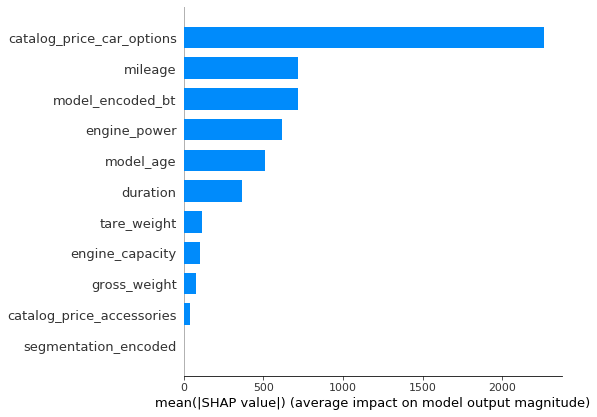

In [16]:
#The feature importance of the regressors in de Hedonic Imputation method
!pip install shap
import shap
import matplotlib.pyplot as pl
model_lgb = models_fin[0]
x_val_ = x_fin[0]
explainer = shap.TreeExplainer(model_lgb)
 
shap_values = explainer.shap_values(x_val_)
shap.summary_plot(shap_values, x_val_, plot_type="bar", show = False)
f = pl.gcf()
f.tight_layout()
#f.savefig('feature_imp_HE.png', dpi=200)

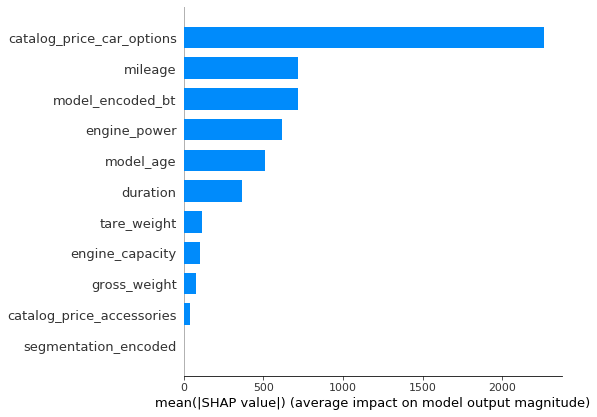

In [31]:
shap_values = explainer.shap_values(x_val_)
shap.summary_plot(shap_values, x_val_, plot_type="bar", show = False)
f = pl.gcf()
f.tight_layout()
f.savefig('feature_imp_HE.png', bbox_inches='tight', dpi=200)

In [ ]:
#Plotting the output
"""import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(model_linear.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png', dpi = 300)
""";